In [51]:
import pandas as pd
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu")

# Paths
dataset_dir = "archive"
img_dir = os.path.join(dataset_dir, "img_align_celeba", "img_align_celeba")
attr_file = os.path.join(dataset_dir, "list_attr_celeba.csv")
landmarks_file = os.path.join(dataset_dir, "list_landmarks_align_celeba.csv")

In [27]:
# load attributes and landmarks
attributes = pd.read_csv(attr_file)
landmarks = pd.read_csv(landmarks_file)

#filter for smiling images
smiling_images = attributes[attributes['Smiling'] == 1]['image_id']

# output directory for masked images
masked_dir = "masked_images"
os.makedirs(masked_dir, exist_ok=True)

# columns for mouth landmarks
mouth_landmarks = ['leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y']

# mask images
for img_name in tqdm(smiling_images, desc="Processing Smiling Images", unit="image"):
    img_path = os.path.join(img_dir, img_name)
    if not os.path.exists(img_path):
        continue

    # load image
    image = Image.open(img_path)
    draw = ImageDraw.Draw(image)
    
    # get landmarks
    img_landmarks = landmarks[landmarks['image_id'] == img_name]
    if img_landmarks.empty:
        continue

    # extract coordinates for the mouth area
    left_x = int(img_landmarks.iloc[0]['leftmouth_x'])
    left_y = int(img_landmarks.iloc[0]['leftmouth_y'])
    right_x = int(img_landmarks.iloc[0]['rightmouth_x'])
    right_y = int(img_landmarks.iloc[0]['rightmouth_y'])

    # calculate a rectangle for the mask

    # extend 5 pixels upward
    top_left = (left_x, min(left_y, right_y) - 5)
    # extend 10 pixels downward
    bottom_right = (right_x, max(left_y, right_y) + 10)
    
    # draw a black mask over the mouth
    draw.rectangle([top_left, bottom_right], fill="black")

    # save masked image
    masked_image_path = os.path.join(masked_dir, img_name)
    image.save(masked_image_path)

Processing Smiling Images: 100%|██████| 97669/97669 [09:59<00:00, 162.81image/s]


In [30]:
# final directories for organizing images
real_dir = "data/real/smiling"
final_masked_dir = "data/masked/smiling"

# create output directories
os.makedirs(real_dir, exist_ok=True)
os.makedirs(final_masked_dir, exist_ok=True)

# move images
for img_name in tqdm(smiling_images, desc="Moving Images", unit="image"):
    real_img_path = os.path.join(img_dir, img_name)
    masked_img_path = os.path.join("masked_images", img_name)

    # copy real images
    if os.path.exists(real_img_path):
        shutil.copy(real_img_path, real_dir)

    # copy masked images
    if os.path.exists(masked_img_path):
        shutil.copy(masked_img_path, final_masked_dir)

Moving Images: 100%|█████████████████| 97669/97669 [01:00<00:00, 1624.78image/s]


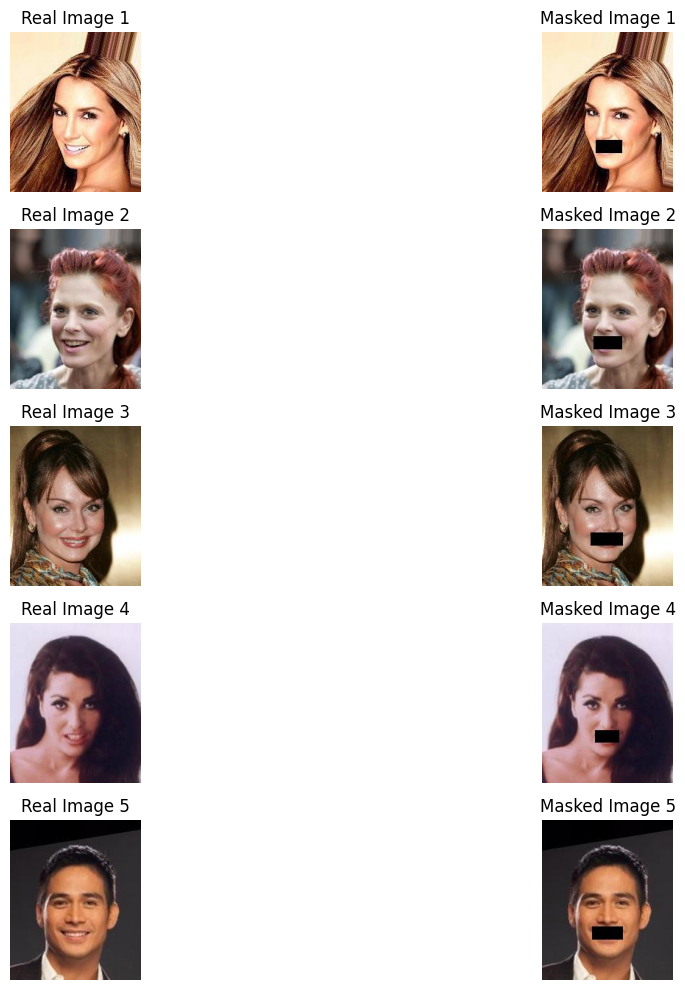

In [31]:
# take the first 5 images
real_images = sorted(os.listdir(real_dir))[:5]

# display images
plt.figure(figsize=(15, 10))
for i, img_name in enumerate(real_images):
    real_img_path = os.path.join(real_dir, img_name)
    masked_img_path = os.path.join(final_masked_dir, img_name)

    real_img = Image.open(real_img_path)
    masked_img = Image.open(masked_img_path)

    plt.subplot(5, 2, i * 2 + 1)
    plt.imshow(real_img)
    plt.title(f"Real Image {i+1}")
    plt.axis("off")

    plt.subplot(5, 2, i * 2 + 2)
    plt.imshow(masked_img)
    plt.title(f"Masked Image {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [32]:
class InpaintingDataset(Dataset):
    def __init__(self, real_dir, masked_dir, transform=None):
        self.real_paths = sorted(os.listdir(real_dir))
        self.masked_paths = sorted(os.listdir(masked_dir))
        self.real_dir = real_dir
        self.masked_dir = masked_dir
        self.transform = transform

    def __len__(self):
        return len(self.real_paths)

    def __getitem__(self, idx):
        real_path = os.path.join(self.real_dir, self.real_paths[idx])
        masked_path = os.path.join(self.masked_dir, self.masked_paths[idx])
        
        real_image = Image.open(real_path).convert("RGB")
        masked_image = Image.open(masked_path).convert("RGB")

        if self.transform:
            real_image = self.transform(real_image)
            masked_image = self.transform(masked_image)

        return masked_image, real_image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = InpaintingDataset(real_dir="data/real/smiling", masked_dir="data/masked/smiling", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [33]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [34]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

Training GAN: 100%|█| 500/500 [00:06<00:00, 82.93epoch/s, D Loss=0.137, G Loss=2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21087497..0.99965113].


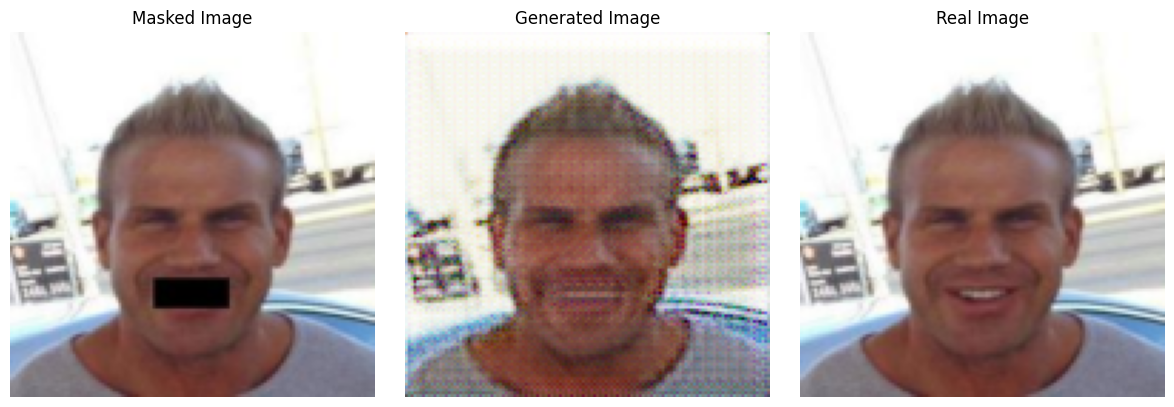

In [35]:
# initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# loss functions
adversarial_loss = nn.BCELoss()  # For real/fake classification
pixelwise_loss = nn.L1Loss()     # For pixel-wise similarity

# optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# load a single image (masked and real)
single_masked_img, single_real_img = next(iter(dataloader))
single_masked_img = single_masked_img[0].unsqueeze(0).to(device)  # Add batch dimension
single_real_img = single_real_img[0].unsqueeze(0).to(device)

# training loop
epochs = 500
with tqdm(total=epochs, desc="Training GAN", unit="epoch") as pbar:
    for epoch in range(epochs):
        # === Train Discriminator ===
        optimizer_D.zero_grad()
        # Real loss
        real_pred = discriminator(single_real_img)
        real_loss = adversarial_loss(real_pred, torch.ones_like(real_pred))
        # Fake loss
        fake_img = generator(single_masked_img)
        fake_pred = discriminator(fake_img.detach())
        fake_loss = adversarial_loss(fake_pred, torch.zeros_like(fake_pred))
        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # === Train Generator ===
        optimizer_G.zero_grad()
        # Adversarial loss (make discriminator think fake images are real)
        fake_pred = discriminator(fake_img)
        g_adversarial_loss = adversarial_loss(fake_pred, torch.ones_like(fake_pred))
        # Pixel-wise loss (make generated image similar to real image)
        g_pixelwise_loss = pixelwise_loss(fake_img, single_real_img)
        # Total generator loss
        g_loss = g_adversarial_loss + g_pixelwise_loss
        g_loss.backward()
        optimizer_G.step()

        # Update tqdm progress bar with losses
        pbar.set_postfix({"D Loss": d_loss.item(), "G Loss": g_loss.item()})
        pbar.update(1)

# save and visualize results
fake_img = fake_img.cpu().detach().squeeze(0)  # Remove batch dimension
real_img = single_real_img.cpu().detach().squeeze(0)
masked_img = single_masked_img.cpu().detach().squeeze(0)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Masked Image")
plt.imshow(masked_img.permute(1, 2, 0).numpy())
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Generated Image")
plt.imshow(fake_img.permute(1, 2, 0).numpy())
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Real Image")
plt.imshow(real_img.permute(1, 2, 0).numpy())
plt.axis("off")

plt.tight_layout()
plt.show()

Training GAN: 100%|█| 500/500 [00:37<00:00, 13.33epoch/s, D Loss=0.265, G Loss=1
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16719331..0.9961907].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13605897..0.952856].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14329456..0.97375005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06265948..0.97376317].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07722474..0.94419056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12627068..0.9508741].
Clipping input data to the valid range fo

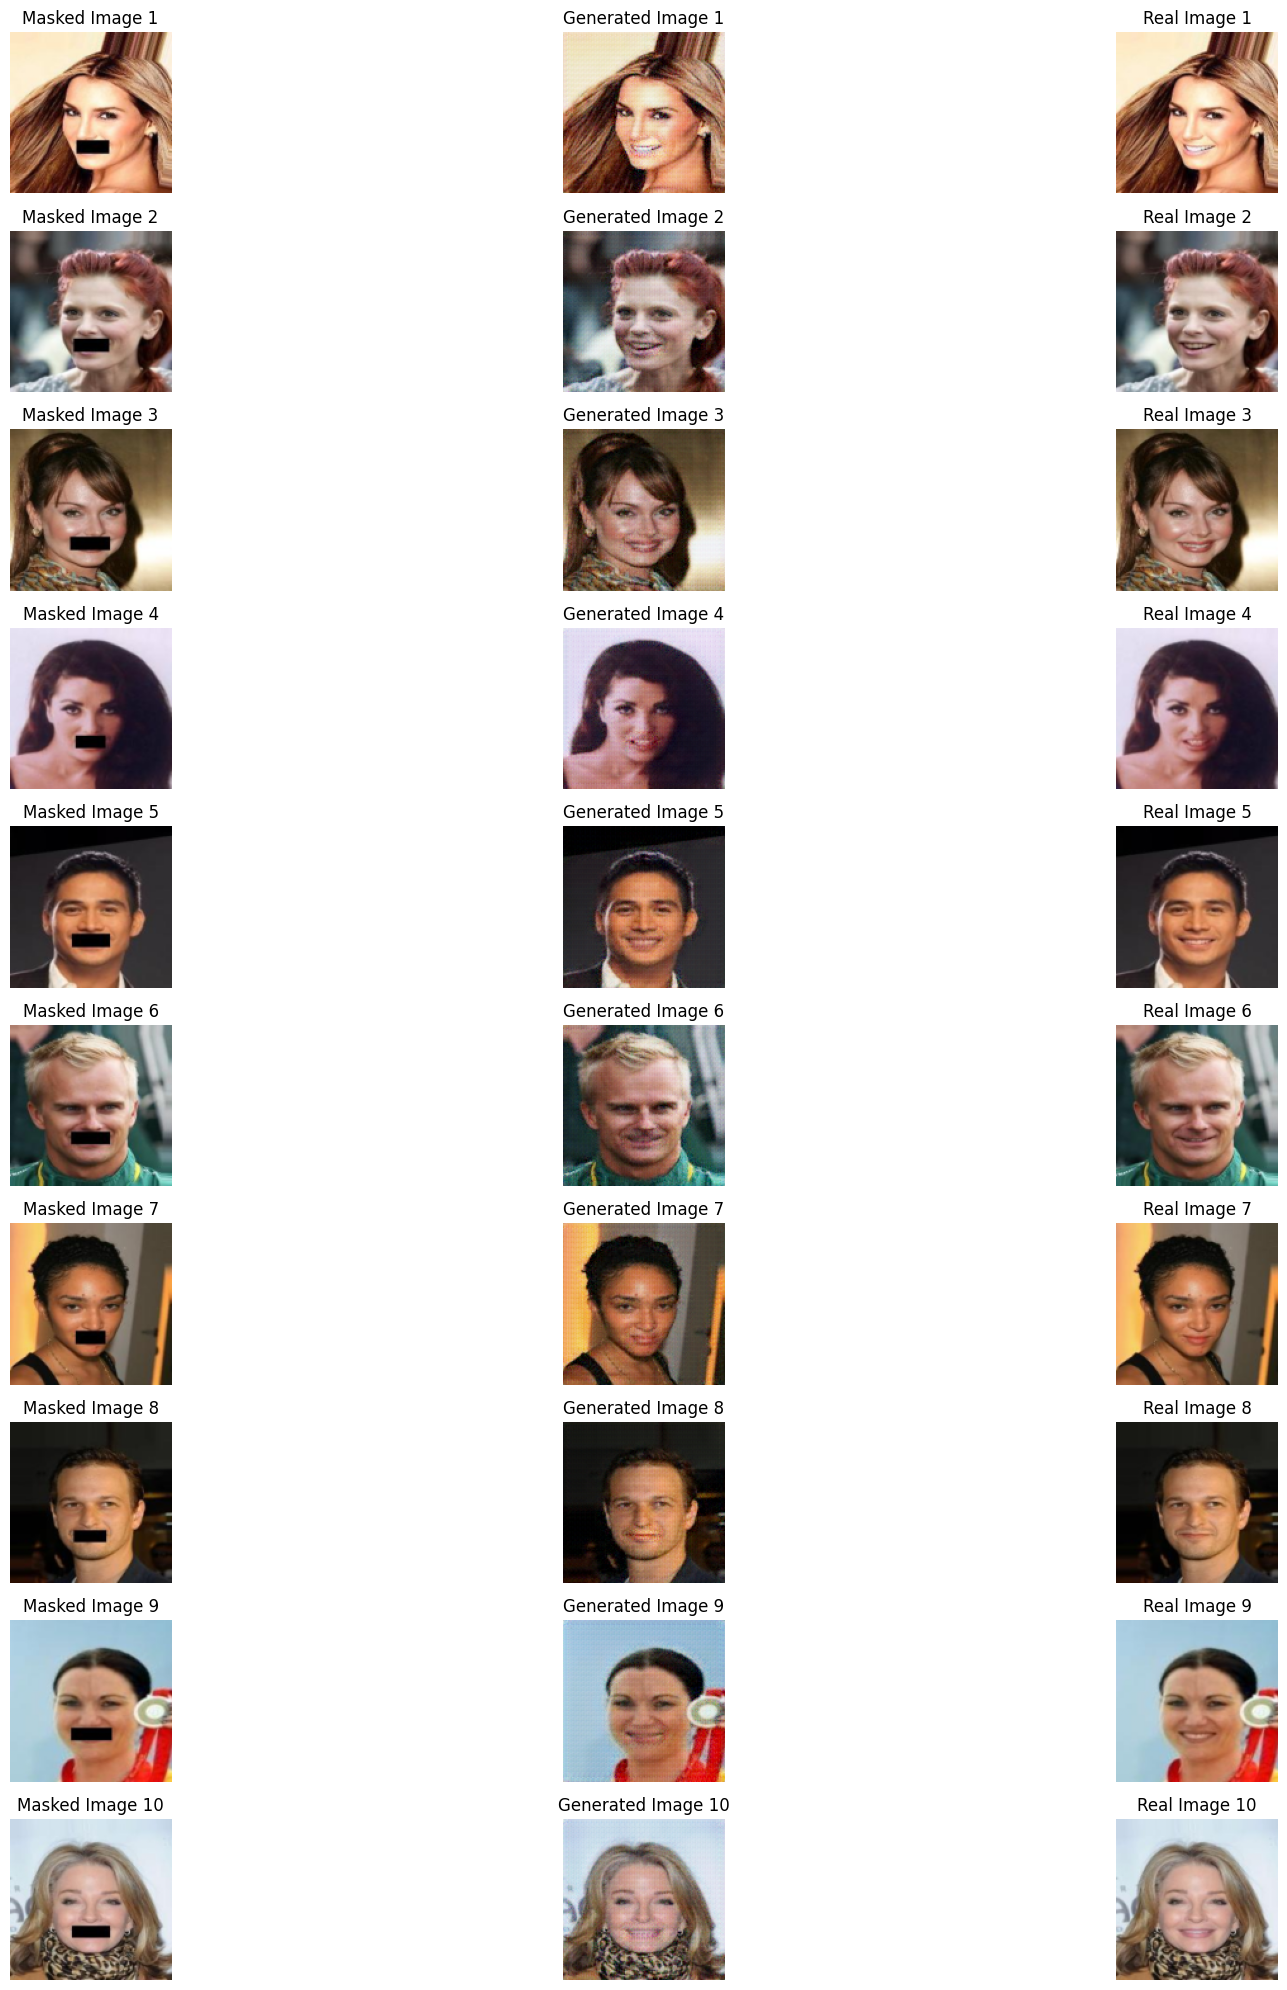

In [50]:
# subset the dataset
subset_indices = list(range(10))
subset_dataset = Subset(dataset, subset_indices)
dataloader = DataLoader(subset_dataset, batch_size=10, shuffle=False, num_workers=0)

# get all 10 images
masked_imgs, real_imgs = next(iter(dataloader))
masked_imgs = masked_imgs.to(device)
real_imgs = real_imgs.to(device)

# Training loop
epochs = 500
with tqdm(total=epochs, desc="Training GAN", unit="epoch") as pbar:
    for epoch in range(epochs):
        # train Discriminator
        optimizer_D.zero_grad()
        real_pred = discriminator(real_imgs)
        real_loss = adversarial_loss(real_pred, torch.ones_like(real_pred))
        fake_imgs = generator(masked_imgs)
        fake_pred = discriminator(fake_imgs.detach())
        fake_loss = adversarial_loss(fake_pred, torch.zeros_like(fake_pred))
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # train Generator
        optimizer_G.zero_grad()
        fake_pred = discriminator(fake_imgs)
        g_adversarial_loss = adversarial_loss(fake_pred, torch.ones_like(fake_pred))
        g_pixelwise_loss = pixelwise_loss(fake_imgs, real_imgs)
        g_loss = g_adversarial_loss + g_pixelwise_loss
        g_loss.backward()
        optimizer_G.step()

        # update tqdm progress bar
        pbar.set_postfix({"D Loss": d_loss.item(), "G Loss": g_loss.item()})
        pbar.update(1)

# visualize all 10 images
fake_imgs = fake_imgs.cpu().detach()
real_imgs = real_imgs.cpu().detach()
masked_imgs = masked_imgs.cpu().detach()

plt.figure(figsize=(20, 20))
for i in range(10):

    plt.subplot(10, 3, i * 3 + 1)
    plt.imshow(masked_imgs[i].permute(1, 2, 0).numpy())
    plt.title(f"Masked Image {i+1}")
    plt.axis("off")

    plt.subplot(10, 3, i * 3 + 2)
    plt.imshow(fake_imgs[i].permute(1, 2, 0).numpy())
    plt.title(f"Generated Image {i+1}")
    plt.axis("off")

    plt.subplot(10, 3, i * 3 + 3)
    plt.imshow(real_imgs[i].permute(1, 2, 0).numpy())
    plt.title(f"Real Image {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Define the proportions for train, validation, and test sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Total size of the dataset
total_size = len(dataset)

# Compute the sizes for each split
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Ensure all samples are included

# split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print sizes of each split
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")